# Transport Map from density

The objective of this example is to show how a transport map can be build in MParT when the the unnormalized probability density function of the target density is known.

## Problem description

We consider $T(\mathbf{z};\mathbf{w})$ a monotone triangular transport map parameterized by $\mathbf{w}$ (e.g., polynomial coefficients). This map which is invertible and has an invertible Jacobian for any parameter $\mathbf{w}$, transports samples $\mathbf{z}^i$ from the reference density $\eta$ to samples $T(\mathbf{z}^i;\mathbf{w})$ from the map induced density $\tilde{\pi}_\mathbf{w}(\mathbf{z})$ defined as:
$$ \tilde{\pi}_\mathbf{w}(\mathbf{z}) = \eta(T^{-1}(\mathbf{z};\mathbf{w}))|\text{det } T^{-1}(\mathbf{z};\mathbf{w})|,$$
where $\text{det } T^{-1}$ is the determinant of the inverse map Jacobian at the point $\mathbf{z}$. We refer to $\tilde{\pi}_{\mathbf{w}}(\mathbf{x})$ as the *map-induced* density or *pushforward distribution* and will commonly interchange notation for densities and measures to use the notation $\tilde{\pi} = T_{\sharp} \eta$.

The objective of this example is, knowing some unnormalized target density $\bar{\pi}$, find the map $T$ that transport samples drawn from $\eta$ to samples drawn from the target $\pi$.

## Imports
First, import MParT and other packages used in this notebook. Note that it is possible to specify the number of threads used by MParT by setting the `KOKKOS_NUM_THREADS` environment variable **before** importing MParT.

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

import os
os.environ['KOKKOS_NUM_THREADS'] = '8'

import mpart as mt
print('Kokkos is using', mt.Concurrency(), 'threads')
plt.rcParams['figure.dpi'] = 110

Kokkos is usingKokkos::OpenMP::initialize WARNING: You are likely oversubscribing your CPU cores.
  process threads available :   2,  requested thread :   8
 8 threads


Kokkos::OpenMP::initialize WARNING: You are likely oversubscribing your CPU cores.
                                    Detected: 2 cores per node.
                                    Detected: 1 MPI_ranks per node.
                                    Requested: 8 threads per process.


## Target density and exact map

In this example we use a 2D target density known as the *banana* density where the unnormalized probability density, samples and the exact transport map are known.

The banana density is defined as:
$$
\pi(x_1,x_2) \propto N_1(x_1)\times N_1(x_2-x_1^2)
$$
where $N_1$ is the 1D standard normal density.

The exact transport map that transport the 2D standard normal density to $\pi$ is known as:
$$
    {T}^\text{true}(z_1,z_2)=
    \begin{bmatrix}
z_1\\
z_2 + z_1^2
\end{bmatrix}
$$

Contours of the target density can be visualized as:

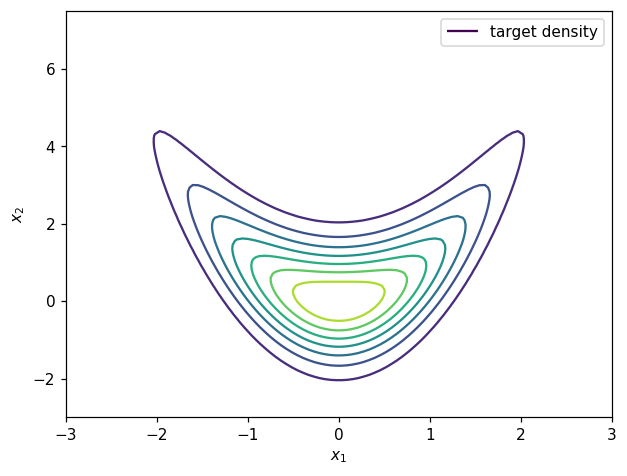

In [2]:
# Unnomalized target density required for objective
def target_logpdf(x): 
  rv1 = multivariate_normal(np.zeros(1),np.eye(1))
  rv2 = multivariate_normal(np.zeros(1),np.eye(1))
  logpdf1 = rv1.logpdf(x[0])
  logpdf2 = rv2.logpdf(x[1]-x[0]**2)
  logpdf = logpdf1 + logpdf2
  return logpdf

# Grid for plotting
ngrid=100
x1_t = np.linspace(-3,3,ngrid)
x2_t = np.linspace(-3,7.5,ngrid)
xx1,xx2 = np.meshgrid(x1_t,x2_t)

xx = np.vstack((xx1.reshape(1,-1),xx2.reshape(1,-1)))

# Target contours
target_pdf_at_grid = np.exp(target_logpdf(xx))

fig, ax = plt.subplots()
CS1 = ax.contour(xx1, xx2, target_pdf_at_grid.reshape(ngrid,ngrid))
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
h1,_ = CS1.legend_elements()
legend1 = ax.legend([h1[0]], ['target density'])
plt.show()

## Map training
### Defining objective function and its gradient
Knowing the closed form of the unnormalized target density $\bar{\pi}$, the objective is to find a map-induced density $\tilde{\pi}_{\mathbf{w}}(\mathbf{z})$ that is a good approximation of the target $\pi$.

In order to characterize this posterior density, one method is to build a monotone triangular transport map $T$ such that the KL divergence $D_{KL}(\eta || T^\sharp \pi)$ is minmized. If $T$ is map parameterized by $\mathbf{w}$, the objective function derived from the discrete KL divergence reads:

$$
J(\mathbf{w}) = - \frac{1}{N}\sum_{i=1}^N \left( \log\pi\left(T(\mathbf{z}^i;\mathbf{w})\right) + \log  \text{det }\nabla_\mathbf{z} T(\mathbf{z}^i;\mathbf{w})\right), \,\,\, \mathbf{z}^i \sim \mathcal{N}(\mathbf{0},\mathbf{I}_d),
$$

where $T$ is the transport map pushing forward the standard normal $\mathcal{N}(\mathbf{0},\mathbf{I}_d)$ to the target density $\pi(\mathbf{z})$. The gradient of this objective function reads

$$
\nabla_\mathbf{w} J(\mathbf{w}) = - \frac{1}{N}\sum_{i=1}^N \left( \nabla_\mathbf{w} T(\mathbf{z}^i;\mathbf{w}).\nabla_\mathbf{x}\log\pi\left(T(\mathbf{z}^i;\mathbf{w})\right) + \nabla_{\mathbf{w}}\log  \text{det }\nabla_\mathbf{z} T(\mathbf{z}^i;\mathbf{w})\right), \,\,\, \mathbf{z}^i \sim \mathcal{N}(\mathbf{0},\mathbf{I}_d).
$$

The objective function and gradient can be defined using MParT as:

In [3]:
# KL divergence objective
def obj(coeffs, transport_map, x):
    num_points = x.shape[1]
    transport_map.SetCoeffs(coeffs)
    map_of_x = transport_map.Evaluate(x)
    logpdf= target_logpdf(map_of_x)
    log_det = transport_map.LogDeterminant(x)
    return -np.sum(logpdf + log_det)/num_points

# Gradient of unnomalized target density required for gradient objective
def target_grad_logpdf(x):
  grad1 = -x[0,:] + (2*x[0,:]*(x[1,:]-x[0,:]**2))
  grad2 = (x[0,:]**2-x[1,:])
  return np.vstack((grad1,grad2))

# Gradient of KL divergence objective
def grad_obj(coeffs, transport_map, x):
    num_points = x.shape[1]
    transport_map.SetCoeffs(coeffs)
    map_of_x = transport_map.Evaluate(x)
    sens_vecs = target_grad_logpdf(map_of_x)
    grad_logpdf = transport_map.CoeffGrad(x, sens_vecs)
    grad_log_det = transport_map.LogDeterminantCoeffGrad(x)
    return -np.sum(grad_logpdf + grad_log_det, 1)/num_points

### Map parameterization

For the parameterization of $T$ we use a total order multivariate expansion of hermite functions. Knowing $T^\text{true}$, any parameterization with total order greater than one will include the true solution of the map finding problem.

In [4]:
# Set-up first component and initialize map coefficients
map_options = mt.MapOptions()

total_order = 2

# Create dimension 2 triangular map 
transport_map = mt.CreateTriangular(2,2,total_order,map_options)

### Approximation before optimization

Coefficients of triangular map are set to 0 upon creation.

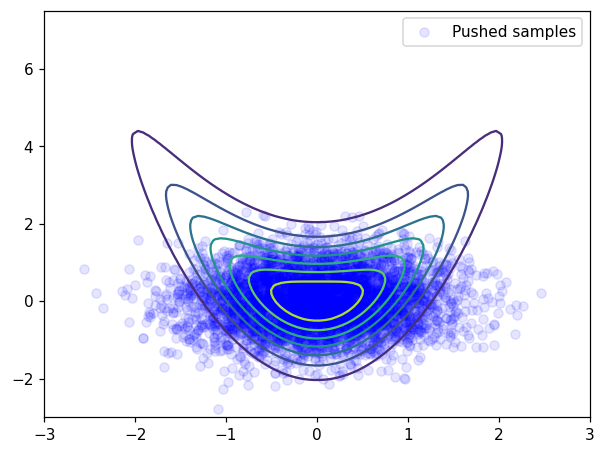

In [5]:
# Make reference samples for training
num_points = 10000
z = np.random.randn(2,num_points)

# Make reference samples for testing
test_z = np.random.randn(2,5000)

# Pushed samples
x = transport_map.Evaluate(test_z)

# Before optimization plot
plt.figure()
plt.contour(xx1, xx2, target_pdf_at_grid.reshape(ngrid,ngrid))
plt.scatter(x[0],x[1], facecolor='blue', alpha=0.1, label='Pushed samples')
plt.legend()
plt.show()

At initialization, samples are "far" from being distributed according to the banana distribution.

Initial objective and coefficients:

In [6]:
# Print initial coeffs and objective
print('==================')
print('Starting coeffs')
print(transport_map.CoeffMap())
print('Initial objective value: {:.2E}'.format(obj(transport_map.CoeffMap(), transport_map, test_z)))
print('==================')

Starting coeffs
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
Initial objective value: 3.39E+00


### Minimization

In [7]:
print('==================')
options={'gtol': 1e-4, 'disp': True}
res = minimize(obj, transport_map.CoeffMap(), args=(transport_map, z), jac=grad_obj, method='BFGS', options=options)

# Print final coeffs and objective
print('Final coeffs:')
print(transport_map.CoeffMap())
print('Final objective value: {:.2E}'.format(obj(transport_map.CoeffMap(), transport_map, test_z)))
print('==================')

Optimization terminated successfully.
         Current function value: 2.844511
         Iterations: 17
         Function evaluations: 19
         Gradient evaluations: 19
Final coeffs:
[-0.01108237  0.84833716  0.00631056  0.98331819  0.84867706  0.00667816
 -0.00985025  0.02820473  2.22978852]
Final objective value: 2.83E+00


### Approximation after optimization

#### Pushed samples

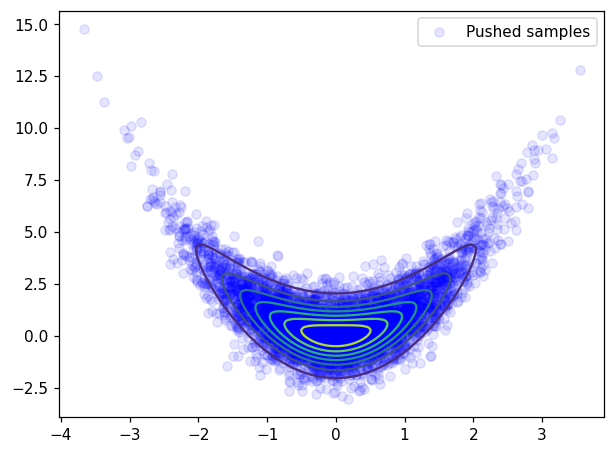

In [8]:
# Pushed samples
x = transport_map.Evaluate(test_z)

# After optimization plot
plt.figure()
plt.contour(xx1, xx2, target_pdf_at_grid.reshape(ngrid,ngrid))
plt.scatter(x[0],x[1], facecolor='blue', alpha=0.1, label='Pushed samples')
plt.legend()
plt.show()

After optimization, pushed samples $T(z^i)$, $z^i \sim \mathcal{N}(0,I)$ are approximately distributed according to the target $\pi$

#### Variance diagnostic

A commonly used accuracy check when facing computation maps from density is the so-called variance diagnostic defined as:

$$ \epsilon_\sigma = \frac{1}{2} \mathbb{V}\text{ar}_\rho \left[ \log \frac{\rho}{T^\sharp \bar{\pi}} \right] $$

This diagnostic is asymptotically equivalent to the minimized KL divergence $D_{KL}(\eta || T^\sharp \pi)$ and should converge to zero when the computed map converge to the true map.

The variance diagnostic can be computed as follow:

In [9]:
def variance_diagnostic(tri_map,ref,target_logpdf,x):
  ref_logpdf = ref.logpdf(x.T)
  y = tri_map.Evaluate(x)
  pullback_logpdf = target_logpdf(y) + tri_map.LogDeterminant(x)
  diff = ref_logpdf - pullback_logpdf
  expect = np.mean(diff)
  var = 0.5*np.mean((diff-expect)**2)
  return var

In [10]:
# Reference distribution
ref_distribution = multivariate_normal(np.zeros(2),np.eye(2));

# Compute variance diagnostic
var_diag = variance_diagnostic(transport_map,ref_distribution,target_logpdf,test_z)

# Print variance diagnostic
print('==================')
print('Variance diagnostic: {:.2E}'.format(var_diag))
print('==================')

Variance diagnostic: 3.13E-04


#### Pushforward density

We can also plot the contour of the unnormalized density $\bar{\pi}$ and the pushforward approximation $T_\sharp \eta$:

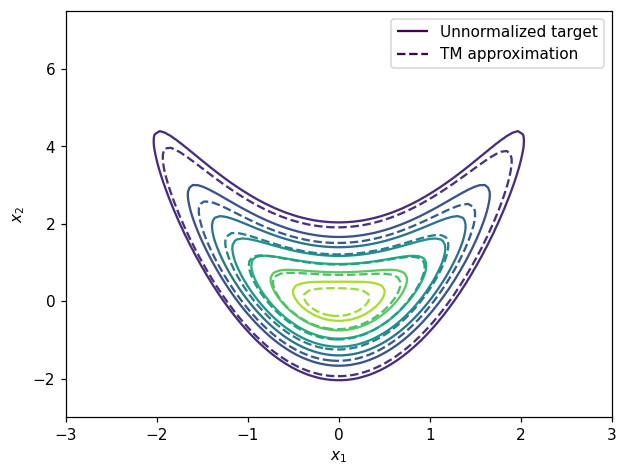

In [11]:
# Pushforward definition
def push_forward_pdf(tri_map,ref,x):
  xinv = tri_map.Inverse(x,x)
  log_det_grad_x_inverse = - tri_map.LogDeterminant(xinv)
  log_pdf = ref.logpdf(xinv.T)+log_det_grad_x_inverse
  return np.exp(log_pdf)

map_approx_grid = push_forward_pdf(transport_map,ref_distribution,xx)

fig, ax = plt.subplots()
CS1 = ax.contour(xx1, xx2, target_pdf_at_grid.reshape(ngrid,ngrid))
CS2 = ax.contour(xx1, xx2, map_approx_grid.reshape(ngrid,ngrid),linestyles='--')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
h1,_ = CS1.legend_elements()
h2,_ = CS2.legend_elements()
legend1 = ax.legend([h1[0], h2[0]], ['Unnormalized target', 'TM approximation'])
plt.show()
